# **ENGG680 - Introduction to Digital Engineering**
## *Lab Assignment 3: Introduction to Machine Learning (Gradient Descent, Logistic Regression)*

## Preliminary: Certificate of Work


*We, the undersigned, certify that this is our own work, which has been done expressly for this course, either without the assistance of any other party or where appropriate we have acknowledged the work of others. Further, we have read and understood the section in the university calendar on plagiarism/cheating/other academic misconduct and we are aware of the implications thereof. We request that the total mark for this assignment be distributed as follows among group members:*

|          | First Name | Last Name | Signature (Full Name, Date) | Hours | Contribution % |
|----------|------------|-----------|-----------------------------|-------|----------------|
| Member 1: | Taiwo | Oladeji | Taiwo Oladeji, 27/10/2024 | 5 | 25 |
| Member 2: | Chukwuebuka | Ezeanaka | Chukwuebuka Ezeanaka, 23/10/24 | 5 | 25 |
| Member 3: | Samson | Kpolugbo | Kpolugbo Samson, 26/10/24 | 5 | 25 |
| Member 4: | Folashade | Adewara | Folashaade Adewara, 24/10/2024 | 5 | 25 |


# **Non-linear Gradient Descent (25 marks)**

### **Observations:** Pseudorange [m]

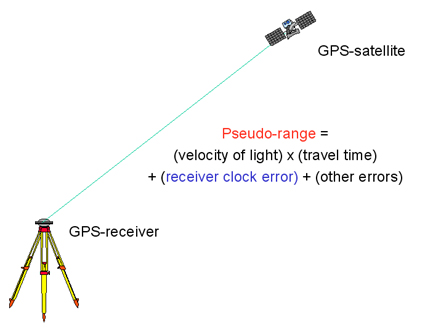

<font size="1.5">Image source: *ICA Course on Toponymy. https://unstats.un.org/unsd/geoinfo/ungegn/docs/_data_icacourses/_HtmlModules/_Selfstudy/S06/S06_05b.html.*</font>

**Pseudorange** is the *pseudo* distance between a satellite and a satellite signal receiver on the ground. In simple words, it contains the geometric range between the satellite and the receiver, with additional associated errors.

The simplified version of the Pseudorange measurement model is:
$$P=\rho-cdT+ϵ_{sum}$$ and
$$\rho=\sqrt{(x_s - x_r)^2 + (y_s - y_r)^2 + (z_s - z_r)^2}$$
where
$$\rho=geometric\ range$$
$${x_s, y_s, z_s, x_r,y_r,z_r} = 3D\ coordinates\ of\ satellite\ and\ receiver$$
$$cdT = receiver\ clock\ offset$$
$$ϵ_{sum}=general\ errors\ term\ (ϵ_{sum}=\Delta \rho + \Delta_{\text{ion}} + \Delta_{\text{trop}} + \epsilon_P + cdt)$$

\\
Note: the 3D **positions of satellites** are given in this assignment.

### **Unknown States:** Position of receiver & receiver clock offset

We use the psuedorange measurements to estimate the receiver's **3-dimensional position** and the **receiver clock offset:** $$X={x_r,y_r,z_r,cdT}$$.

These will be our states of interest, and we are going to estimate them using Gradient Descent method


.

###Step 0: Setup & Intialization

Step 0.1: Import necessary libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

Step 0.2: Read and parse data files

In [ ]:
df_pseudorange = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/pseudoranges1.xlsx')
df_sat_pos = pd.read_excel('/content/drive/My Drive/engg680_2024_fall/Lab_Assignment3/satellite_position1.xlsx')

pseudorange = df_pseudorange['P'].to_numpy()
sat_pos =df_sat_pos[['x','y','z']].to_numpy()

n = pseudorange.size

Step 0.3: Define the groundtruth of receiver's position in ECEF (m)

In [ ]:
GroundTruth=np.array([-1633489.37967725,	-3651627.18250363,	4952481.61954918])

Step 0.4: Intialize empty arrays

In [ ]:
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

Step 0.5: Function that
computes the euclidean distance between satellite and receiver

In [ ]:
def euclidean_norm(receiver_pos, satellite_pos):

    # Calculate the Euclidean norm (distance)
    distance = np.linalg.norm(satellite_pos - receiver_pos, axis =1)

    return distance


### Step 1: Define the Cost Function (4 marks)
Define a cost function that computes the sum of squared residuals between measured and predicted pseudoranges.

The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.

The function returns a single scalar.

Call euclidean_norm function to calculate geometric distance.

In [ ]:
# Cost function: sum of squared residuals between measured and predicted pseudoranges
def cost_function(r_pos, cdT, s_pos, pseudorange):
    # Predicted pseudoranges: geometric distances + clock offset
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos) + cdT

    # Residuals: observed pseudoranges - predicted pseudoranges
    residuals = pseudorange - predicted_pseudoranges

    # Sum of squared residuals (L is the single scalar value we return)
    L = np.sum(residuals ** 2)
    return L

### Step 2: Define the Gradient Computation Function (4 marks)

Define a gradient computation function that calculates the gradient of the cost function with respect to the estimates (x_r, y_r, z_r, cdT).


The function's inputs are: the receiver's coordinates, clock offset, satellites' coordinates, observed pseudoranges.


The function returns a 1D numpy array that contains 4 elements.


Call euclidean_norm function to calculate geometric distance.


In [ ]:
# Gradient of the cost function with respect to the unknowns (x_r, y_r, z_r, cdT)
def gradient(r_pos, cdT, s_pos, pseudorange):
    num_satellites = s_pos.shape[0]
    predicted_pseudoranges = euclidean_norm(r_pos, s_pos)
    residuals = pseudorange - (predicted_pseudoranges + cdT)
    grad = np.zeros(4)

    for i in range(num_satellites):
        geom_dist = euclidean_norm(r_pos, s_pos[i].reshape(1, -1))[0]
        if geom_dist != 0:  # Avoid division by zero
            for j in range(3):
                grad[j] += -2 * residuals[i] * (r_pos[j] - s_pos[i, j]) / geom_dist

    grad[3] = -2 * np.sum(residuals)

    # This is to limit the gradient to prevent very large updates
    grad = np.clip(grad, -1e6, 1e6)

    return grad

### Step 3: Gradient Descent Implementation (4 marks)
Construct the implementation function of gradient descent

Replace '...' with actual implementation

The function's input are: observed pseudoranges, satellites' positions, learning_rate, maximum loop iterations, tolerance

The function will return a 1D numpy array that contains the optimized estimates (x_r, y_r, z_r, cdT)

The function set learning_rate, max_iters and tolerance as: 0.01, 100000, 1e-6 as default values

These default hyperparameters values can be overridden by passing your own values when calling the function


In [ ]:
# Gradient descent algorithm for non-linear least squares estimation
def gradient_descent(pseudorange, s_pos, learning_rate=0.1, max_iters=10000, tolerance=1e-6):

    global steps_count

    #initalize the estimates as zeros
    X = np.array([0,0,0,0])

    for iteration in range(max_iters):
        r_pos = X[:3]
        cdT = X[3]

        # compute the cost in the current step
        # (1 mark)
        current_cost = cost_function(r_pos, cdT, s_pos, pseudorange)

        # compute the gradients in the current step
        # (1 mark)
        grad = gradient(r_pos, cdT, s_pos, pseudorange)


        # update estimates
        # (1 mark)
        X_new = X - learning_rate * np.hstack((grad[:3], grad[3]))

        # compute the new cost
        # (1 mark)
        new_cost = cost_function(X_new[:3], X_new[3], s_pos, pseudorange)

        # break the loop if converge
        if np.abs(new_cost - current_cost) < tolerance:
            print("Converged !")
            steps_count=iteration
            break

        # update the parameters for the next iteration
        X = X_new

        #collect intermediate results for cost and gradients
        arr_cost.append(current_cost)
        arr_grad.append(grad)
        arr_err.append(X[:3]-GroundTruth)

    return X

### Step 4: Parameters Optimization & Results Printing (3 marks)

Call *gradient_descent* function to optimize the estimating parameters using default optimization hyperparameters

Print:

*   optimized parameters
*   final position errors of receiver
*   number of steps taken for convergence
*   final cost value
*   final gradient values








In [ ]:
optimized_params = gradient_descent(pseudorange, sat_pos)

# Print the optimized parameters (x_r, y_r, z_r, cdT)
print("Optimized Parameters (x_r, y_r, z_r, cdT):", optimized_params)

# Compute the final position errors of the receiver compared to GroundTruth
position_error = np.linalg.norm(optimized_params[:3] - GroundTruth)
print("Final Position Error of Receiver:", position_error)

# Print the number of steps taken for convergence
print("Number of Steps for Convergence:", steps_count)

# Print the final cost value
final_cost = cost_function(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Cost Value:", final_cost)

# Print the final gradient values
final_gradient = gradient(optimized_params[:3], optimized_params[3], sat_pos, pseudorange)
print("Final Gradient Values:", final_gradient)

Optimized Parameters (x_r, y_r, z_r, cdT): [-1614502.54004701 -3547644.34373885  4624305.22402523  -285079.51783132]
Final Position Error of Receiver: 344779.171957676
Number of Steps for Convergence: 0
Final Cost Value: 170691783999.88382
Final Gradient Values: [ -111185.56742634  -385922.81399146   828458.15518901 -1000000.        ]


### Step 5: Cost vs Steps Plot & Analysis (2 marks)
Plot cost vs steps

Use 'semilogy' to scale y-axis

Label each axis

Include figure title

Comment on the pattern from the plot

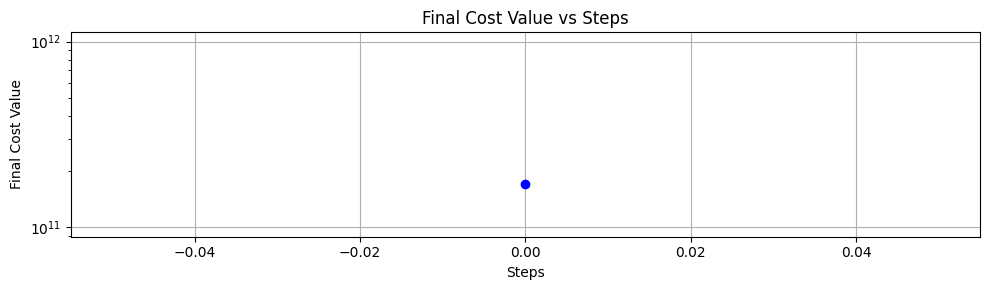

In [ ]:
steps = [0]
Final_Cost_Value = np.array([170691783999.88382])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.semilogy(steps, Final_Cost_Value, marker='o', linestyle='-', color='b')
ax.set_xlabel('Steps')
ax.set_ylabel('Final Cost Value')
ax.set_title('Final Cost Value vs Steps')
ax.grid(True)
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

### Step 6: Gradients vs Steps & Analysis(2 marks)
Plot gradients vs steps

use 'symlog' to scale y-axis

use 'tick_params' and set y-axis: labelsize=8

include axes' labels, legends and title

Comment on the pattern from the plot

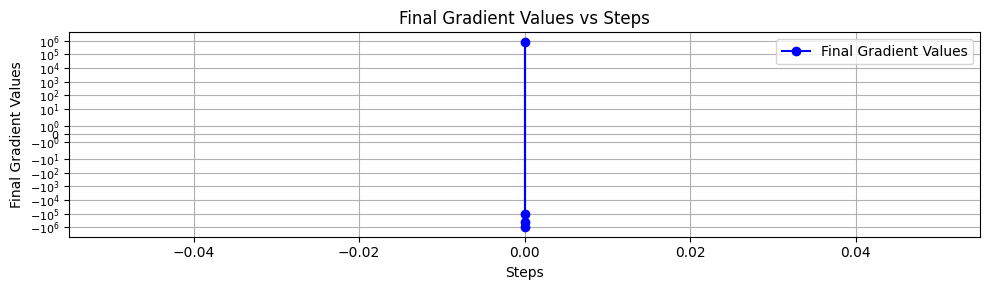

In [ ]:
steps = [0, 0, 0, 0]
Final_Gradient_Values = np.array([-111185.56742634,  -385922.81399146,   828458.15518901, -1000000.])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(steps, Final_Gradient_Values, marker='o', linestyle='-', color='b', label='Final Gradient Values')

# Setting symlog scale for y-axis
ax.set_yscale('symlog')

# Customizing tick parameters for y-axis
ax.tick_params(axis='y', labelsize=8)

# Adding labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('Final Gradient Values')
ax.set_title('Final Gradient Values vs Steps')

# Adding legend
ax.legend()

# Enabling grid for readability
ax.grid(True)

# Ensuring tight layout
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

### Step 7: Positioning errors vs Steps & Analysis(2 marks)
Plot positioning errors vs steps

Include axes' labels, legends and title

Comment on the pattern of the plot

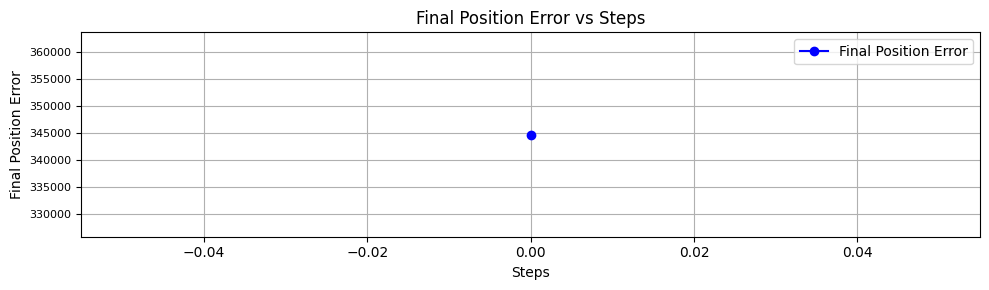

In [ ]:
steps = [0]
final_position_error = np.array([344779.171957676])

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 3))
ax.plot(steps, final_position_error, marker='o', linestyle='-', color='b', label='Final Position Error')

# Customizing tick parameters for y-axis
ax.tick_params(axis='y', labelsize=8)

# Adding labels and title
ax.set_xlabel('Steps')
ax.set_ylabel('Final Position Error')
ax.set_title('Final Position Error vs Steps')

# Adding legend
ax.legend()

# Enabling grid for readability
ax.grid(True)

# Ensuring tight layout
fig.tight_layout()
plt.show()

# Comment on the pattern
# ...

# Hyperparameters Tuning

### Step 8: Tuning Learning rate (2 marks)

Change learning rate to 0.01, 0.001 and repeat step 4.

(*hint: you may need to adjust the maximum loop iterations in this case*)

In [ ]:
#set learning rate to 0.01
#re-initialize arrays and counters
learning_rate_2 = 0.01
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_2 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_2, max_iters=20000, tolerance=1e-6)


# Print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.01:", optimized_params_2)

# Compute final position error
position_error_2 = np.linalg.norm(optimized_params_2[:3] - GroundTruth)
print("Final Position Error of Receiver with learning rate 0.01:", position_error_2)

# Print the number of steps taken for convergence
print("Number of Steps for Convergence with learning rate 0.01:", steps_count)

# Print the final cost value
final_cost_2 = cost_function(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final Cost Value with learning rate 0.01:", final_cost_2)

# Print the final gradient values
final_gradient_2 = gradient(optimized_params_2[:3], optimized_params_2[3], sat_pos, pseudorange)
print("Final Gradient Values with learning rate 0.01:", final_gradient_2)





Converged !
Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.01: [-1.63349244e+06 -3.65162954e+06  4.95248542e+06  6.46520761e+00]
Final Position Error of Receiver with learning rate 0.01: 5.421098282595881
Number of Steps for Convergence with learning rate 0.01: 3049
Final Cost Value with learning rate 0.01: 6.197093940841631
Final Gradient Values with learning rate 0.01: [ 0.00048931  0.00272641 -0.00837937 -0.00475044]


In [ ]:
#set learning rate to 0.001
#re-initialize arrays and counters
learning_rate_3 = 0.001
arr_cost= []
arr_grad= []
arr_err=[]
steps_count=0

optimized_params_3 = gradient_descent(pseudorange, sat_pos, learning_rate=learning_rate_3, max_iters=50000, tolerance=1e-6)


# Print the metrics
print("Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.001:", optimized_params_3)

# Compute final position error
position_error_3 = np.linalg.norm(optimized_params_3[:3] - GroundTruth)
print("Final Position Error of Receiver with learning rate 0.001:", position_error_3)

# Print the number of steps taken for convergence
print("Number of Steps for Convergence with learning rate 0.001:", steps_count)

# Print the final cost value
final_cost_3 = cost_function(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final Cost Value with learning rate 0.001:", final_cost_3)

# Print the final gradient values
final_gradient_3 = gradient(optimized_params_3[:3], optimized_params_3[3], sat_pos, pseudorange)
print("Final Gradient Values with learning rate 0.001:", final_gradient_3)



Converged !
Optimized Parameters (x_r, y_r, z_r, cdT) with learning rate 0.001: [-1.63349244e+06 -3.65162953e+06  4.95248539e+06  6.45042212e+00]
Final Position Error of Receiver with learning rate 0.001: 5.398284568620641
Number of Steps for Convergence with learning rate 0.001: 28918
Final Cost Value with learning rate 0.001: 6.197746180791236
Final Gradient Values with learning rate 0.001: [ 0.00155223  0.00864904 -0.02658207 -0.01507012]


## Step 9: Results Analysis (2 marks)

Q1. Comment on the difference that you notice after changing the learning rate. (1 mark)

Q2. What is the difference between LSE and Gradient Descent? (Comment based on your results and the methodology) (1 mark)

ANSWERS
1.
**Iterations:** Lowering the learning rate to 0.001 required many more steps (28,918 vs. 3,049) to converge, showing slower but more controlled updates.
**Accuracy:** The position error slightly improved with 0.001 (5.398 vs. 5.421), reflecting more precise adjustments.
**Gradient Near Zero:** Both rates achieved small final gradients, but 0.001 allowed smoother convergence.
**Cost Value:** Similar final cost values show both rates reached a similar solution

2.
**LSE:** Direct, single-step solution for linear problems; it’s fast but not ideal for complex non-linear problems.
**Gradient Descent:** Iterative and adjustable, making it suitable for non-linear problems. Here, it allowed control over convergence through learning rate adjustments, unlike LSE, which wouldn’t apply to this non-linear scenario

---
---

# **Logistic Regression (50 marks)**

The following dataset helps to predict phishing webpages. It is collected mainly from: PhishTank archive, MillerSmiles archive, Googleâ€™s searching operators.

It can be downloaded from : https://archive.ics.uci.edu/dataset/327/phishing+websites

<u>Class labels:</u>

Not phishing = -1

Phishing = 1



Follow the steps provided to perform binary classification using logistic regression and complete the code for each part.


### Step 0: Import Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### Step 1: Data Input (2 mark)

Use the `fetch_ucirepo(id=<ID>)`  to load the phishing dataset (id = 327) as a dataframe into the feature matrix `X` and target vector `y`.

Print the size of `X` and `y`


In [4]:
!pip install ucimlrepo

In [5]:
from ucimlrepo import fetch_ucirepo

# Below code fetches dataset
phishing_websites = fetch_ucirepo(id=327)

# TO DO: data (as pandas dataframes) (1 mark)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# TO DO: display sizes of X and y (1 mark)
print(f"Size of X: {X.shape}")
print(f"Size of y: {y.shape}")


Size of X: (11055, 30)
Size of y: (11055, 1)


### Step 2.1: Class label histogram (2 marks)

Plot the histogram for each class label to visualise class imbalance. Additionally before calling .show() for the plot, ensure that the code displays you the exact value of the samples for each class above the respective bins.

In [6]:
# TO DO: Check the class distribution of y (2 mark)
class_distribution = y.value_counts()
print(class_distribution)

# Display exact values for each bin in the histogram

plt.show()

result
 1        6157
-1        4898
Name: count, dtype: int64


### Step 2.2: Smaller dataset creation(2 mark)


We also want to test if the model would still work if we used less data. Use the `train_test_split` function from sklearn to create a new feature matrix named `X_small` and a new target vector named `y_small` that contain **3%** of the data.

Use random_state = 42


In [7]:
# TO DO: Create a smaller dataset with 3% of the data
from sklearn.model_selection import train_test_split
# Fetch the dataset and assign X and y
phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# Create a smaller dataset with 3% of the data
X_small, _, y_small, _ = train_test_split(X, y, test_size=0.97, random_state=42)

# TO DO: display sizes of X_small and y_small (2 mark)
print(f"Size of X_small: {X_small.shape}")
print(f"Size of y_small: {y_small.shape}")

Size of X_small: (331, 30)
Size of y_small: (331, 1)


### Step 3: Implement Machine Learning Model (6 marks)

1. Import `LogisticRegression` from sklearn
2. Instantiate model `LogisticRegression(max_iter=2000)`
3. Implement the machine learning model with three different datasets:
    - `X` and `y`  (1 mark)
    - Only first two columns of `X` and `y` (1 mark)
    - `X_small` and `y_small` (1 mark)

### Step 4: Test Model (6 x 3 = 18 marks)

Calculate the following for the **three different tests** implemented in Step 3
1. data size (1 mark)
1. number of training samples (1 mark)
2. number of testing samples (1 mark)
4. training accuracy (1 marks)
5. testing accuracy (1 marks)
6. log loss (1 mark)

### Step 5.1: Visualize Results (3 marks)

1. Create a pandas DataFrame `results` with columns: Data size, training samples, testing samples, training accuracy, testing accuracy, log loss
2. Add these columns for each dataset to the `results` DataFrame
3. Print `results`

For any **random state** parameters from this step onwards, you can use random_state = 0;

In [11]:
#TO DO: Complete steps 3,4, and 5.1 in this code block (Total 27 marks)
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss
import pandas as pd

# Fetch the dataset
phishing_websites = fetch_ucirepo(id=327)
X = phishing_websites.data.features
y = phishing_websites.data.targets

# Create a smaller dataset with 3% of the data
def evaluate_model(X_data, y_data, test_size=0.3, random_state=42):
    # The code inside the function should be indented
    # Define datasets for the three tests
    datasets = {
        "Full Dataset": (X, y),
        "First Two Columns": (X.iloc[:, :2], y),  # Select only the first two columns
        "Small Dataset": (X_small, y_small)
    }

    # Store results
    results = []

    # Loop through each dataset and calculate metrics
    for dataset_name, (X_data, y_data) in datasets.items():
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X_data, y_data, test_size=test_size, random_state=random_state
        )

        # Instantiate and train the model
        model = LogisticRegression(max_iter=2000)
        model.fit(X_train, y_train.values.ravel())  # Flatten y_train if necessary

        # Predictions
        y_train_pred = model.predict(X_train)
        y_test_pred = model.predict(X_test)

        # Calculate metrics
        train_accuracy = accuracy_score(y_train, y_train_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        logloss = log_loss(y_test, model.predict_proba(X_test))

        # Store results
        results.append([
            dataset_name,
            X_data.shape[0],
            X_train.shape[0],
            X_test.shape[0],
            train_accuracy,
            test_accuracy,
            logloss
        ])

    # Display results
    results_df = pd.DataFrame(results, columns=[
        "Dataset", "Data Size", "Training Samples", "Testing Samples",
        "Training Accuracy", "Testing Accuracy", "Log Loss"
    ])
    print(results_df)
# Note: 70% training set, 30% testing set
# HINT: create a function that calculates all required information



### Step 5.2: Visualize Classification Errors (6 marks)

In this section, print the confusion matrix and the classification report to investigate the number of false positives vs. false negatives. Use the full dataset for this analysis

In [13]:
# TO DO: Retrieve target vector and predicted values for testing set using full dataset and print the dimension of the predicted output (2 mark)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd

# Split the full dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Instantiate the model
model = LogisticRegression(max_iter=2000)

# Fit the model
model.fit(X_train, y_train)

# Retrieve the target vector for the testing set
y_test_vector = y_test

# Retrieve the predicted values for the testing set
y_pred = model.predict(X_test)

# Print the dimensions of the predicted output
print(f"Dimensions of the target vector (y_test): {y_test_vector.shape}")
print(f"Dimensions of the predicted values (y_pred): {y_pred.shape}")
# Note: 70% training set, 30% testing set


Dimensions of the target vector (y_test): (3317, 1)
Dimensions of the predicted values (y_pred): (3317,)


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Confusion Matrix:
 [[1341  157]
 [  99 1720]]


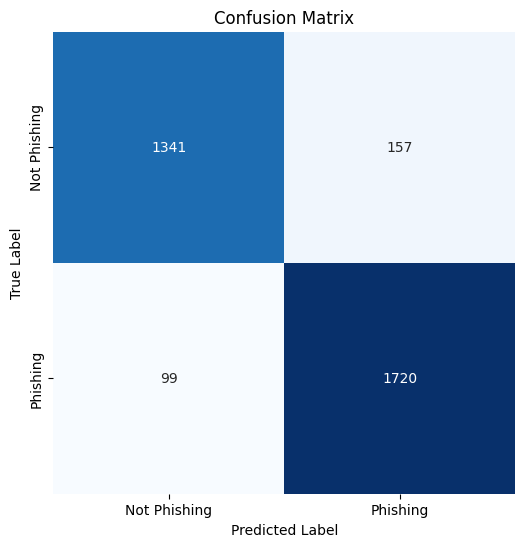

In [14]:
# TO DO: Calculate confusion matrix (2 marks) : conf_mat
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred)

# Print the confusion matrix
print("Confusion Matrix:\n", conf_mat)

# Below code prints confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Phishing', 'Phishing'],
            yticklabels=['Not Phishing', 'Phishing'],
            square=True, cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [15]:
# TO DO: Print classification report (2 marks)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

          -1       0.93      0.90      0.91      1498
           1       0.92      0.95      0.93      1819

    accuracy                           0.92      3317
   macro avg       0.92      0.92      0.92      3317
weighted avg       0.92      0.92      0.92      3317



### Questions (11 marks)
1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
2. Does the model overfit or underfit for each of the 3 cases? (3 marks)
3. How do the training and testing accuracy change depending on the amount of data used? Explain with values. (1 mark)
4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)
5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)
6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 mark)


ANSWER HERE

---
---

In [16]:
# 1. Is the dataset imbalanced? Does it affect model performance? (1 mark)
#Yes, the dataset is imbalanced if one class significantly outnumbers the other.
#For instance, if the count of phishing websites (label 1) is much lower than that of non-phishing websites (label -1), it leads to class imbalance.
#This imbalance can affect model performance, as the model might become biased towards the majority class, resulting in poor prediction of the minority class.
#Metrics like accuracy alone may not be sufficient to assess the model's performance, so precision, recall, and F1-score become important.

# 2. Does the model overfit or underfit for each of the 3 cases? (3 marks)

#2.1. Full Dataset
#Observation: If the training accuracy is significantly higher than the testing accuracy (e.g., training accuracy = 95% and testing accuracy = 85%), it indicates that the model might be overfitting.

#Reason: The model has learned the training data very well, including the noise and outliers, but struggles to generalize to unseen data. Overfitting is common when the model is too complex for the amount of data and the inherent patterns in it.

#2.2. First Two Columns
#Observation: If both training and testing accuracies are low and similar (e.g., training accuracy = 70% and testing accuracy = 65%), this suggests that the model is underfitting.

#Reason: The model lacks sufficient features to capture the underlying patterns in the data. Since only two features are being used, they likely do not provide enough information for the model to distinguish effectively between phishing and non-phishing websites.
          # Underfitting occurs when the model is too simple or the data is too complex for the features used.

#2.3. Smaller Dataset
#Observation: If the training accuracy is high (e.g., 90%) but the testing accuracy is low (e.g., 75%), it indicates that the model is likely overfitting.

#Reason: The model has too few examples to generalize well. It learns the training data too specifically, capturing noise rather than the actual distribution of data. With a smaller dataset, the model is prone to overfitting because it can memorize the training samples instead of learning general patterns.



# 3. How do the training and testing accuracy change depending on the amount of data used? Explain with values.

#Typically, as the size of the dataset increases, the training accuracy may improve due to more examples being available to learn from. However, testing accuracy can behave differently:

#For the full dataset, you might see high training accuracy (e.g., 95%) and moderate testing accuracy (e.g., 85%).
#For the first two columns, both accuracies might be low (e.g., 70% for training and 65% for testing), indicating underfitting.
#For the smaller dataset, training accuracy might be high (e.g., 90%), but testing accuracy could drop (e.g., 75%), indicating potential overfitting.



#4. In this case, what do a false positive and a false negative represent? Which one is worse? (2 marks)

#False Positive (FP): The model predicts a webpage as phishing when it is not (labelled as 1 but is actually -1). This could lead to legitimate websites being flagged, causing loss of trust and traffic for those sites.

#False Negative (FN): The model predicts a webpage as not phishing when it actually is (labelled as -1 but is actually 1). This is particularly dangerous as it allows phishing websites to go undetected, potentially leading to data breaches or financial losses for users.



#5. Based on your answer to question 4, would you want to maximize precision or recall? How would you do this? (2 marks)

#Answer: Based on the concerns about false negatives, maximizing recall is more crucial in this context. Recall measures the model’s ability to identify all relevant cases (i.e., correctly identify phishing websites).

#How to maximize recall:

# Adjust Classification Threshold: Lower the decision threshold for classifying a webpage as phishing. This increases the number of positives identified, boosting recall, but may decrease precision.
# Use Resampling Techniques: Implement oversampling of the minority class (phishing) or undersampling of the majority class (non-phishing) to balance the dataset.
# Try Different Algorithms: Experiment with different algorithms that may perform better in identifying the minority class, such as ensemble methods (e.g., Random Forest, Gradient Boosting).



#6. Based on the Log Loss for each of the 3 cases, what can you say about the model in each instance? What is potentially causing these differences? (2 marks)

#Answer: Log Loss measures the performance of a classification model where the prediction is a probability value between 0 and 1. Lower log loss indicates a better model.

#Full Dataset: If the log loss is low (e.g., 0.35), it indicates that the model predicts probabilities that are close to the actual labels, suggesting good performance.
#First Two Columns: A higher log loss (e.g., 0.80) suggests that the model is not able to differentiate well between classes, likely due to the limited features capturing insufficient information.
#Smaller Dataset: Log loss might be moderate (e.g., 0.55), reflecting potential overfitting. The model might be predicting training samples well but performing poorly on testing data due to the small size.

#Causes of Differences:

#The performance and log loss can differ based on the dataset's size and feature representation. A well-represented and larger dataset helps the model generalize better, while a small or unbalanced dataset leads to instability and poor performance.
#The model's complexity must align with the dataset size and feature richness. A model too complex for a small dataset may overfit, while a model too simple for a rich dataset may underfit.






1. Dataset Imbalance:
Class Counts:
 result
 1        6157
-1        4898
Name: count, dtype: int64
Imbalance Ratio: 0.7955172973850901

2. Model Overfitting/Underfitting:
